In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import product
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
# Strategy function (as before)
def calculate_bitcoin_volatility_managed_strategy(
    start_date, end_date, lookback_period=20, risk_on_threshold=0.8,
    risk_off_threshold=1.2, initial_value=100.0, leverage=3.0
):
    # Fetch historical Bitcoin data
    btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
    
    # Ensure the data is continuous
    btc_data = btc_data.asfreq('D').ffill()
    
    # Calculate daily returns
    btc_data['BTC Returns'] = btc_data['Adj Close'].pct_change()
    
    # Simulate leveraged Bitcoin returns
    btc_data['Leveraged BTC Returns'] = btc_data['BTC Returns'] * leverage
    
    # Calculate rolling volatility (annualized)
    # Ensure lookback_period is an integer
    lookback_period = int(lookback_period)
    if lookback_period <= 0:
        raise ValueError("lookback_period must be a positive integer")
    btc_data['BTC Volatility'] = btc_data['BTC Returns'].rolling(window=lookback_period).std() * np.sqrt(252)
    
    # Initialize strategy DataFrame
    strategy_df = pd.DataFrame(index=btc_data.index)
    strategy_df['Strategy Value'] = initial_value
    strategy_df['Position'] = 'Stablecoin'  # Start in stablecoin
    strategy_df['Daily Returns'] = 0.0
    
    # Initial position
    position = 'Stablecoin'
    
    # Loop starting from lookback_period to ensure volatility is available
    for i in range(lookback_period, len(strategy_df)):
        current_volatility = btc_data.iloc[i]['BTC Volatility']
        previous_position = position

        # Strategy logic with risk_on and risk_off thresholds
        if pd.isna(current_volatility):
            # Stay in the previous position if volatility is NaN
            position = previous_position
        else:
            if position == 'Stablecoin' and current_volatility <= risk_on_threshold:
                position = 'Leveraged BTC'
            elif position == 'Leveraged BTC' and current_volatility >= risk_off_threshold:
                position = 'Stablecoin'

        # Update position
        strategy_df.iloc[i, strategy_df.columns.get_loc('Position')] = position

        # Update strategy value based on position
        if position == 'Leveraged BTC':
            daily_return = btc_data.iloc[i]['Leveraged BTC Returns']
        else:
            daily_return = 0  # Stablecoin assumed to have zero return

        # Apply transaction costs if position changes
        if position != previous_position:
            transaction_cost = strategy_df.iloc[i-1]['Strategy Value'] * 0.001  # Assuming 0.1% transaction cost
            strategy_value = (strategy_df.iloc[i-1]['Strategy Value'] - transaction_cost) * (1 + daily_return)
        else:
            strategy_value = strategy_df.iloc[i-1]['Strategy Value'] * (1 + daily_return)

        # Update strategy value and returns
        strategy_df.iloc[i, strategy_df.columns.get_loc('Strategy Value')] = strategy_value
        strategy_df.iloc[i, strategy_df.columns.get_loc('Daily Returns')] = strategy_value / strategy_df.iloc[i-1]['Strategy Value'] - 1

    # Remove initial NaN values (up to lookback_period)
    strategy_df = strategy_df.iloc[lookback_period:]

    return strategy_df, btc_data

# Performance metrics function (as before)
def calculate_performance_metrics(strategy_returns):
    metrics = {}
    strategy_returns = strategy_returns.dropna()
    trading_days = len(strategy_returns)
    if trading_days == 0:
        return None  # No data to calculate metrics

    cumulative_return = (1 + strategy_returns).prod() - 1
    total_years = trading_days / 252  # Assuming 252 trading days per year
    annualized_return = (1 + cumulative_return) ** (1 / total_years) - 1 if total_years > 0 else 0.0

    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    risk_free_rate = 0.0  # Assuming risk-free rate is zero
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else np.nan

    cumulative_returns = (1 + strategy_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    target_return = 0.0  # Assuming zero as the target (risk-free rate)
    downside_returns = strategy_returns[strategy_returns < target_return]
    downside_deviation = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

    metrics['Annualized Return'] = annualized_return
    metrics['Annualized Volatility'] = annualized_volatility
    metrics['Sharpe Ratio'] = sharpe_ratio
    metrics['Sortino Ratio'] = sortino_ratio
    metrics['Max Drawdown'] = max_drawdown
    metrics['Final Value'] = cumulative_return + 1

    return metrics

# Optimization function without multiprocessing
def optimize_strategy(
    start_date, end_date, metric_to_optimize, 
    risk_on_range, risk_off_range, lookback_period_range,leverage_range):
    """
    Optimizes the strategy parameters to maximize the selected performance metric.

    Parameters:
    - start_date: Start date for the data.
    - end_date: End date for the data.
    - metric_to_optimize: Performance metric to optimize ('CAGR', 'Final Value', 'Sharpe Ratio', 'Sortino Ratio').
    - risk_on_range: List of risk_on_threshold values to test.
    - risk_off_range: List of risk_off_threshold values to test.
    - lookback_period_start: Start value for lookback_period.
    - lookback_period_step: Step value for lookback_period.
    - lookback_period_end: End value for lookback_period.
    - leverage_start: Start value for leverage.
    - leverage_step: Step value for leverage.
    - leverage_end: End value for leverage.

    Returns:
    - best_params: Dictionary of best parameters found.
    - best_metrics: Performance metrics of the best parameters.
    - results_df: DataFrame containing all tested parameters and their performance metrics.
    """

    # Define parameter grid
    param_grid = list(product(risk_on_range, risk_off_range, lookback_period_range, leverage_range))
    
    all_results = []

    # Function to evaluate a single parameter combination
    def evaluate_params(params):
        risk_on_threshold, risk_off_threshold, lookback_period, leverage = params

        try:
            strategy_df, btc_data = calculate_bitcoin_volatility_managed_strategy(
                start_date, end_date, lookback_period, risk_on_threshold, risk_off_threshold, initial_value=100.0, leverage=leverage
            )

            metrics = calculate_performance_metrics(strategy_df['Daily Returns'])
            if metrics is None:
                return None

            # Buy-and-hold performance metrics
            buy_and_hold_returns = btc_data['BTC Returns'].dropna()
            buy_and_hold_metrics = calculate_performance_metrics(buy_and_hold_returns)
            if buy_and_hold_metrics is None:
                return None

            # Map the metric name to the dictionary key
            metric_mapping = {
                'CAGR': 'Annualized Return',
                'Final Value': 'Final Value',
                'Sharpe Ratio': 'Sharpe Ratio',
                'Sortino Ratio': 'Sortino Ratio'
            }

            optimized_metric_value = metrics.get(metric_mapping[metric_to_optimize], None)

            if optimized_metric_value is None or np.isnan(optimized_metric_value):
                return None

            result = {
                'Risk On Threshold': risk_on_threshold,
                'Risk Off Threshold': risk_off_threshold,
                'Lookback Period': lookback_period,
                'Leverage': leverage,
                'Strategy Annualized Return': metrics['Annualized Return'],
                'Strategy Annualized Volatility': metrics['Annualized Volatility'],
                'Strategy Sharpe Ratio': metrics['Sharpe Ratio'],
                'Strategy Sortino Ratio': metrics['Sortino Ratio'],
                'Strategy Max Drawdown': metrics['Max Drawdown'],
                'Strategy Final Value': metrics['Final Value'],
                'Buy-and-Hold Annualized Return': buy_and_hold_metrics['Annualized Return'],
                'Buy-and-Hold Annualized Volatility': buy_and_hold_metrics['Annualized Volatility'],
                'Buy-and-Hold Sharpe Ratio': buy_and_hold_metrics['Sharpe Ratio'],
                'Buy-and-Hold Sortino Ratio': buy_and_hold_metrics['Sortino Ratio'],
                'Buy-and-Hold Max Drawdown': buy_and_hold_metrics['Max Drawdown'],
                'Buy-and-Hold Final Value': buy_and_hold_metrics['Final Value'],
                'Optimized Metric': optimized_metric_value
            }

            return result
        except Exception as e:
            # In case of any error, skip this parameter set
            return None

    # Evaluate parameters sequentially
    for params in param_grid:
        result = evaluate_params(params)
        if result is not None:
            all_results.append(result)

    results_df = pd.DataFrame(all_results)

    # Check if any results were collected
    if results_df.empty:
        print("No valid results found during optimization.")
        return None, None, None

    # Find the best parameters
    if metric_to_optimize in ['Annualized Volatility', 'Max Drawdown']:
        # For volatility and drawdown, lower is better
        best_row = results_df.loc[results_df['Optimized Metric'].idxmin()]
    else:
        # For other metrics, higher is better
        best_row = results_df.loc[results_df['Optimized Metric'].idxmax()]

    best_params = {
        'Risk On Threshold': best_row['Risk On Threshold'],
        'Risk Off Threshold': best_row['Risk Off Threshold'],
        'Lookback Period': best_row['Lookback Period'],
        'Leverage': best_row['Leverage']
    }

    best_metrics = best_row.to_dict()

    return best_params, best_metrics, results_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Optimization Complete. Best parameters to maximize CAGR:
Risk On Threshold: 0.8000000000000003
Risk Off Threshold: 0.6000000000000001
Lookback Period: 10.0
Leverage: 3.0

Performance Metrics Comparison:


,Metric,Volatility-Managed Strategy,Buy-and-Hold Strategy
0,Annualized Return,147.45%,45.97%
1,Annualized Volatility,107.96%,57.94%
2,Sharpe Ratio,136.58%,79.33%
3,Sortino Ratio,183.95%,104.17%
4,Max Drawdown,-98.03%,-83.40%
5,Final Value,34921893.16%,20886.40%


[*********************100%%**********************]  1 of 1 completed


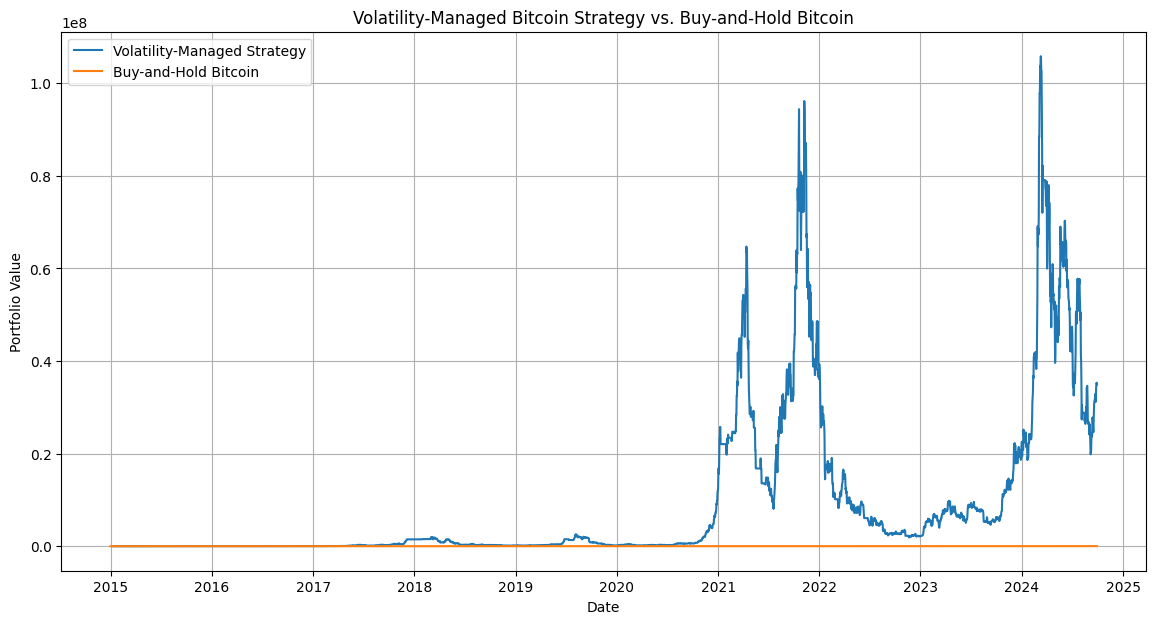

In [3]:
# Example usage
if __name__ == "__main__":
    # Define the parameters to optimize
    start_date = '2015-01-01'
    end_date = '2024-09-30'
    metric_to_optimize = 'CAGR'  # Options: 'CAGR', 'Final Value', 'Sharpe Ratio', 'Sortino Ratio'

    # Define ranges for each parameter
    risk_on_range = np.arange(0.2, 0.8, 0.1).tolist()
    risk_off_range = np.arange(0.2, 0.8, 0.1).tolist()
    lookback_period_range = list(range(10, 40, 5))
    leverage_range = np.arange(1, 4, 1).tolist()

    # Run the optimization
    best_params, best_metrics, results_df = optimize_strategy(
        start_date, end_date, metric_to_optimize,
        risk_on_range, risk_off_range,lookback_period_range,leverage_range)

    # Check if optimization was successful
    if best_params is not None:
        # Display the best parameters
        print(f"Optimization Complete. Best parameters to maximize {metric_to_optimize}:")
        print(f"Risk On Threshold: {best_params['Risk On Threshold']}")
        print(f"Risk Off Threshold: {best_params['Risk Off Threshold']}")
        print(f"Lookback Period: {best_params['Lookback Period']}")
        print(f"Leverage: {best_params['Leverage']}\n")

        # Create a DataFrame to compare the metrics of the best strategy and buy-and-hold
        metrics_comparison = pd.DataFrame({
            'Metric': [
                'Annualized Return',
                'Annualized Volatility',
                'Sharpe Ratio',
                'Sortino Ratio',
                'Max Drawdown',
                'Final Value'
            ],
            'Volatility-Managed Strategy': [
                best_metrics['Strategy Annualized Return'],
                best_metrics['Strategy Annualized Volatility'],
                best_metrics['Strategy Sharpe Ratio'],
                best_metrics['Strategy Sortino Ratio'],
                best_metrics['Strategy Max Drawdown'],
                best_metrics['Strategy Final Value']
            ],
            'Buy-and-Hold Strategy': [
                best_metrics['Buy-and-Hold Annualized Return'],
                best_metrics['Buy-and-Hold Annualized Volatility'],
                best_metrics['Buy-and-Hold Sharpe Ratio'],
                best_metrics['Buy-and-Hold Sortino Ratio'],
                best_metrics['Buy-and-Hold Max Drawdown'],
                best_metrics['Buy-and-Hold Final Value']
            ]
        })

        # Format the DataFrame
        metrics_comparison['Volatility-Managed Strategy'] = metrics_comparison['Volatility-Managed Strategy'].apply(lambda x: f"{x:.2%}")
        metrics_comparison['Buy-and-Hold Strategy'] = metrics_comparison['Buy-and-Hold Strategy'].apply(lambda x: f"{x:.2%}")

        print("Performance Metrics Comparison:")
        display(metrics_comparison)

        # Plot the strategy performance using the best parameters
        strategy_df, btc_data = calculate_bitcoin_volatility_managed_strategy(
            start_date, end_date,
            best_params['Lookback Period'],
            best_params['Risk On Threshold'],
            best_params['Risk Off Threshold'],
            initial_value=100.0,
            leverage=best_params['Leverage']
        )

        # Plot the strategy performance
        plt.figure(figsize=(14, 7))
        plt.plot(strategy_df.index, strategy_df['Strategy Value'], label='Volatility-Managed Strategy')

        # Calculate buy-and-hold Bitcoin performance
        btc_data['Cumulative Returns'] = (1 + btc_data['BTC Returns'].fillna(0)).cumprod()
        plt.plot(btc_data.index, 100.0 * btc_data['Cumulative Returns'], label='Buy-and-Hold Bitcoin')

        plt.title('Volatility-Managed Bitcoin Strategy vs. Buy-and-Hold Bitcoin')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Optimization failed. Please check your parameter ranges and data.")


In [4]:
# Optimization Complete. Best parameters to maximize Sharpe Ratio:
# Risk On Threshold: 0.2
# Risk Off Threshold: 0.5000000000000001
# Lookback Period: 25.0
# Leverage: 3.0

# Performance Metrics Comparison:
# Metric	Volatility-Managed Strategy	Buy-and-Hold Strategy
# 0	Annualized Return	93.51%	45.97%
# 1	Annualized Volatility	50.06%	57.94%
# 2	Sharpe Ratio	186.79%	79.33%
# 3	Sortino Ratio	135.38%	104.17%
# 4	Max Drawdown	-57.97%	-83.40%
# 5	Final Value	1051230.80%	20886.40%